In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


This notebook prepares a folder of files for input to a Self Organizing Map (SOM). Primarily, this means dataset normalization by Principle Component Analysis (PCA), and dimentionality reduction using the Discrete Cosine Transform (DCT). Another option for dimentionality reduction is using an autoencoder, which will be explored in a seperate notebook.

In [2]:
import numpy as np
import pandas as pd
import rasterio as rio
from tqdm import tqdm
import os, sys
from scipy.fftpack import dct, idct
import scipy as sp
from sklearn import decomposition as decomp

Step 1: Read in the data
----------------------------------

In [5]:
# replace path name to your directory that has data for the SOM
tile_dir = "/home/espg/test_tile/output/"
file_list = os.listdir(tile_dir)


In [6]:
file_list[0]

'd644764912685a51381f2a349db7914b36bb80b1ddd351c94789319fc91ae707.tif'

In [7]:
test1 = rio.open(tile_dir + file_list[0])

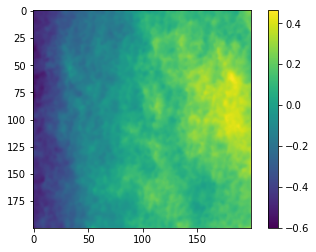

In [17]:
imshow(test1.read()[0])
colorbar()

Step 2: Define Functions and Masking Arrays
------------------------------------------

In [18]:
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

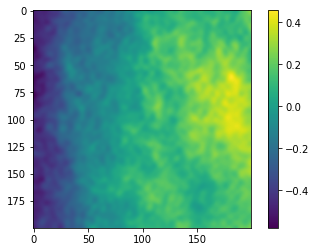

In [26]:
# testing above function
a = test1.read()[0]
c = dct2(a)

smaller = zeros_like(c)
smaller[:50,:50] = c[:50,:50]
imshow(idct2(smaller))
colorbar()

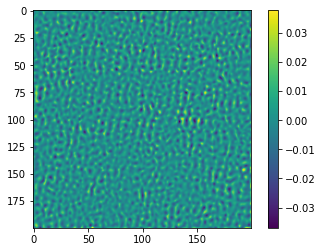

In [25]:
imshow(a - idct2(smaller))
colorbar()

In [27]:
# Circular Masking
# This is applied pre- PCA
radius = 99.5

kernel = np.zeros((int(2*radius+1), int(2*radius+1)), dtype=bool)
y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
mask = x**2 + y**2 <= radius**2
kernel[mask] = 1

In [28]:
# Circular Masking
# This is applied post- PCA
radius2 = 70.5

kernel2 = np.zeros((int(2*radius2+1), int(2*radius2+1)), dtype=bool)
y2,x2 = np.ogrid[-radius2:radius2+1, -radius2:radius2+1]
mask2 = x2**2 + y2**2 <= radius2**2
kernel2[mask2] = 1

In [29]:
TL = ~kernel2
TL[71:] = 0
TL[:,71:] = 0

TR = ~kernel2
TR[71:] = 0
TR[:,:71] = 0

In [30]:
# Shared and Re-used data structures and objects

# Local coordinate grid; same for all tiles
X, Y = np.meshgrid(r_[-49.75:50:.5],r_[-49.75:50:.5])

# Masked coordinate locations
xCoords = X[kernel]
yCoords = Y[kernel]

# PCA object
pca = decomp.PCA()

Step 3: Run the normalization
-----------------------------------------

In [31]:
# Create empty data structure to fill

tiles = len(file_list)

# Since slope is calulated by the PCA, we'll save it
gross_slope = np.zeros((tiles))

dataDCT = np.ones((tiles,5041),dtype=numpy.float32) # Reduced dimentionality!!!

reduced_data = np.ones((tiles,20164),dtype=numpy.float32)

In [32]:
# Do the thing

for i in tqdm(range(tiles)):
    tile_ = rio.open(tile_dir + file_list[i]).read()[0]
    orgin = np.vstack((X.ravel(),Y.ravel(),tile_.ravel()))
    zCoords = tile_[kernel]
    stacked = np.vstack((xCoords,yCoords,zCoords))
    
    pca.fit(stacked.T)
    # Sanity check to make sure third componet is always slope??
    gross_slope[i] = numpy.degrees(numpy.arccos(np.dot(np.abs(pca.components_[2]),
                                                       np.array([0,0,1]))))
    
    XY, Values = np.dot(orgin.T,pca.components_.T)[:,:2], np.dot(orgin.T,pca.components_.T)[:,2]
    
    normed = sp.interpolate.griddata(XY,Values,orgin.T[:,:2],'linear')
    
    reduced = normed.reshape(200,200)[29:-29,29:-29]

    
    if np.isnan(reduced).any():
        nanmask = np.isnan(reduced)
        filler = sp.interpolate.griddata(XY,Values,orgin.T[:,:2],'nearest')
        fill = filler.reshape(200,200)[29:-29,29:-29]
        reduced[nanmask] = fill[nanmask]
    
    
    
    circ = np.zeros((142,142))
    circ[kernel2] = reduced[kernel2]
    
    transformed = dct2(circ)
    #transformed = dct2(reduced)
    
    trans_duced = transformed[:71,:71]
    
    dataDCT[i,:5041] = trans_duced.ravel()
    
    # For comparision / sanity checking
    reduced_data[i,:] = circ.ravel() #reduced.ravel() # circ.ravel()
    
    if np.isnan(circ).any():
        #imshow(reduced_data[i].reshape(142,142))
        print(i)
    
    # Need to test for flips!!!

100%|██████████| 9/9 [00:06<00:00,  1.44it/s]


For runs that are hundreds of thousands of tiles, probably worth using multiprocessing...

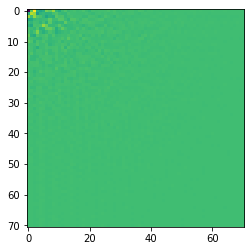

In [36]:
# Test that it worked
imshow(dataDCT[0].reshape(71,71))

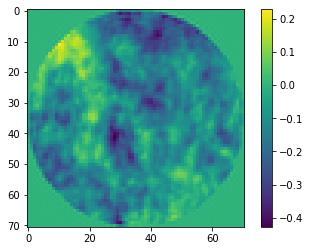

In [46]:
imshow(idct2(dataDCT[0].reshape(71,71)))
colorbar()

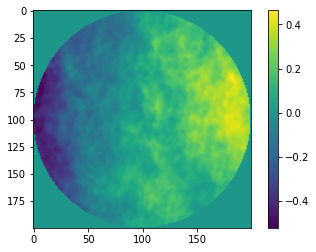

In [43]:
imshow(test1.read()[0]*kernel)
colorbar()

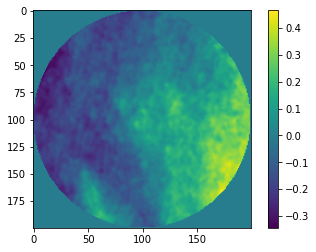

In [61]:
testing = rio.open(tile_dir + file_list[6]).read()[0]
imshow(testing*kernel)
colorbar()

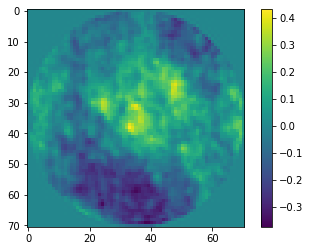

In [62]:
imshow(idct2(dataDCT[6].reshape(71,71)))
colorbar()

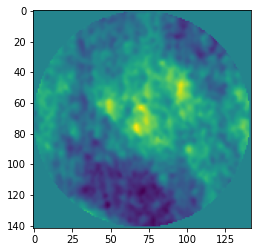

In [64]:
# 'Full' resolution data, with the detrending/normalization
# This is the array that would get passed to an auto-encoder
# ...saved for that reason. Also, useful to quantify resolution
# reduction impacts on the SOM output (i.e., to verify that there isn't an impact)
imshow(reduced_data[6].reshape(142,142))

In [65]:
# Save the output to disk

np.save('./Full_DataDCT.npy', dataDCT)
np.save('./Full_GrossSlope.npy', gross_slope)
np.save('./Full_reducedData.npy', reduced_data)